In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import scipy

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from hsmm4acc import hsmm
from milleniumcohort import create_config

In [4]:
config = create_config('../config.yml')
config.create_data_paths()

In [5]:
import sqlite3
conn = sqlite3.connect(os.path.join(config.model_path, 'milleniumcohort.db'))

## Load data in database

In [6]:
config.model_path

'/media/sf_VBox_Shared/London/CLSdata500/results/mod_10st_0b_15r_720t_acceleration_anglex_angley_anglez'

In [7]:
# Import data with states
filenames = os.listdir(config.states_path)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(config.states_path,fn))]

In [8]:
# Only do this if database is not filled yet!
fill_again = False
if(fill_again):
    c = conn.cursor()
    c.execute('drop table if exists data_with_states')
    for fn in filenames:
        dataset = pd.read_csv(os.path.join(config.states_path,fn), encoding='utf-8', index_col='timestamp', parse_dates=True)
        if len(dataset[dataset["state"].isnull()])>0 :
            print(fn)
        dataset.to_sql('data_with_states', conn, if_exists='append')


In [12]:
pd.read_sql('Select count(distinct filename), count(*) from data_with_states', conn)

,count(distinct filename),count(*)
0,459,7248060


In [13]:
pd.read_sql('pragma table_info(data_with_states)', conn)

,cid,name,type,notnull,dflt_value,pk
0,0,timestamp,TIMESTAMP,0,None,0
1,1,acceleration,REAL,0,None,0
2,2,EN,REAL,0,None,0
3,3,anglex,REAL,0,None,0
4,4,angley,REAL,0,None,0
5,5,anglez,REAL,0,None,0
6,6,roll_med_acc_x,REAL,0,None,0
7,7,roll_med_acc_y,REAL,0,None,0
8,8,roll_med_acc_z,REAL,0,None,0
9,9,dev_roll_med_acc_x,REAL,0,None,0


## Preperation

In [9]:
states = pd.read_sql('Select distinct state from data_with_states', conn)

In [10]:
len(states)

10

In [11]:
# Load simplified activities map
activities_simplified = pd.read_csv(config.activities_simplified_path, header=0, sep=',', dtype=str, encoding='utf-8')
levelmap = {'0': "low", '1': "high", '2':"mixed"}
def get_category_des(motion, arm_changes):
    return levelmap[motion]+" motion, " + levelmap[arm_changes] + " arm changes"
activities_simplified['simplified_category'] = [get_category_des(row[1], row[2]) for row in activities_simplified.get_values()]
#activities_simplified.to_sql('activities_simplified', conn)

In [12]:

heuristic_classes = [' 1 - sustained activity',  #1
                     ' 2 - non-bouted inactivity', #2
                     ' 3 - >=30min inactivity', #3 
                     ' 4 - 10-19min inactivity', #4
                     ' 5 - non-bouted LPA', #5
                     ' 6 - >=10min LPA', #6
                     ' 7 - 1-9min LPA', #7
                     ' 8 - non-bouted MVPA', #8
                     ' 9 - >=10min MVPA', #9
                    '10 - 1-9min MVPA' #10
                     ]
get_heuristic = lambda i: heuristic_classes[int(i)-1]

## Get subjects with >20 hour data

In [18]:
timecounts = pd.read_sql('Select filename, count(*) from data_with_states group by filename', conn)

In [19]:
timecounts = timecounts.set_index('filename')
timecounts.columns = ['cnt_5sec']
timecounts['cnt_hours'] = timecounts['cnt_5sec'] / (12.0 * 60)

In [20]:
if fill_again:
    timecounts.to_sql('timecounts', conn)

In [21]:
longdays = timecounts[timecounts['cnt_hours']>=24].index
longdays.shape

(275,)

## Calculate per-state statistics

In [13]:
numerical_columns = ['acceleration','EN',
        'anglex','angley',u'anglez',u'roll_med_acc_x',u'roll_med_acc_y',
        u'roll_med_acc_z',u'dev_roll_med_acc_x',
             u'dev_roll_med_acc_y',u'dev_roll_med_acc_z']
query = '''Select state, ''' +  ','.join(['avg({})'.format(co) for co in numerical_columns]) + '''
from data_with_states group by state'''

avg_bystate = pd.read_sql(query, conn)

In [23]:
avg_bystate = avg_bystate.set_index('state').transpose()
avg_bystate.index = numerical_columns

In [24]:
means = avg_bystate.loc[config.hsmmconfig.column_names]
means.style.background_gradient(cmap='coolwarm',axis=1)

In [25]:
# Get a practical ordering of the states: based on the mean acceleration values
state_order = means.loc['acceleration'].sort_values().index
state_order

Int64Index([1, 2, 0, 9, 3, 7, 8, 4, 5, 6], dtype='int64', name=u'state')

In [26]:
means[state_order]

state,1,2,0,9,3,7,8,4,5,6
acceleration,0.000038,0.005463,0.019775,0.028074,0.061479,0.067868,0.08862,0.102175,0.197512,0.550417


In [14]:
query = '''Select heuristic, avg(acceleration), avg(anglex), avg(angley), avg(anglez)
from data_with_states group by heuristic'''
avg_byheuristic = pd.read_sql(query, conn)

In [17]:
avg_byheuristic.set_index('heuristic').transpose()

heuristic,1,2,3,4,5,6,7,8,9,10
avg(acceleration),0.000000,0.014483,0.013252,0.013281,0.071556,0.077255,0.075113,0.220445,0.310514,0.286698
avg(anglex),-5.282657,-27.929270,-22.462861,-23.618555,-32.074456,-32.026591,-32.587560,-30.329905,-27.711697,-28.270852
avg(angley),3.348760,1.418854,7.188957,6.101260,-4.706643,7.034684,-4.346561,-10.514911,-17.906368,-14.952752
avg(anglez),-9.568755,-2.843846,-7.543019,-5.818258,-1.520773,-19.256500,-0.529047,0.341939,1.867893,2.512602


In [24]:
query = '''
select a.heuristic, mean_acc, mean_x, mean_y, mean_z, 
      avg(acceleration - mean_acc) as sigma_acc,
      avg(anglex - mean_x) as sigma_x,
      avg(angley - mean_y) as sigma_y,
      avg(anglez - mean_z) as sigma_z
from data_with_states a
left join (
    Select heuristic, avg(acceleration) as mean_acc, 
           avg(anglex) as mean_x, 
           avg(angley) as mean_y, 
           avg(anglez) as mean_z 
    from data_with_states group by heuristic
)b on a.heuristic = b.heuristic
group by a.heuristic
'''
avgsig_byheuristic = pd.read_sql(query, conn)

In [25]:
avgsig_byheuristic

,heuristic,mean_acc,mean_x,mean_y,mean_z,sigma_acc,sigma_x,sigma_y,sigma_z
0,1,0.000000,-5.282657,3.348760,-9.568755,0.000000e+00,1.684277e-13,1.125420e-13,1.320686e-13
1,2,0.014483,-27.929270,1.418854,-2.843846,-2.779289e-16,5.478442e-13,-6.181990e-14,1.613238e-13
2,3,0.013252,-22.462861,7.188957,-7.543019,2.282035e-16,1.483213e-13,9.821733e-13,9.115809e-14
3,4,0.013281,-23.618555,6.101260,-5.818258,1.294852e-16,-4.202298e-13,1.371737e-13,-5.142207e-15
4,5,0.071556,-32.074456,-4.706643,-1.520773,-1.984495e-15,1.503100e-12,6.794610e-14,2.949507e-14
5,6,0.077255,-32.026591,7.034684,-19.256500,-1.180701e-16,-4.412373e-14,-4.418744e-15,8.734957e-15
6,7,0.075113,-32.587560,-4.346561,-0.529047,-2.524537e-16,3.343749e-13,1.153634e-13,-1.546736e-14
7,8,0.220445,-30.329905,-10.514911,0.341939,-2.548189e-15,-4.760180e-13,-2.211293e-13,7.949496e-15
8,9,0.310514,-27.711697,-17.906368,1.867893,-5.932506e-15,1.400694e-14,1.869858e-13,1.731126e-14
9,10,0.286698,-28.270852,-14.952752,2.512602,3.448600e-15,-7.279072e-15,-5.100591e-14,7.851829e-15


In [ ]:
avgsig_byheuristic = avgsig_byheuristic.set_index('heuristic').transpose()
avgsig_byheuristic.columns = heuristic_classes

In [28]:
avgsig_byheuristic

,1 - sustained activity,2 - non-bouted inactivity,3 - >=30min inactivity,4 - 10-19min inactivity,5 - non-bouted LPA,6 - >=10min LPA,7 - 1-9min LPA,8 - non-bouted MVPA,9 - >=10min MVPA,10 - 1-9min MVPA
mean_acc,0.000000e+00,1.448328e-02,1.325163e-02,1.328063e-02,7.155574e-02,7.725479e-02,7.511252e-02,2.204445e-01,3.105145e-01,2.866978e-01
mean_x,-5.282657e+00,-2.792927e+01,-2.246286e+01,-2.361855e+01,-3.207446e+01,-3.202659e+01,-3.258756e+01,-3.032991e+01,-2.771170e+01,-2.827085e+01
mean_y,3.348760e+00,1.418854e+00,7.188957e+00,6.101260e+00,-4.706643e+00,7.034684e+00,-4.346561e+00,-1.051491e+01,-1.790637e+01,-1.495275e+01
mean_z,-9.568755e+00,-2.843846e+00,-7.543019e+00,-5.818258e+00,-1.520773e+00,-1.925650e+01,-5.290471e-01,3.419387e-01,1.867893e+00,2.512602e+00
sigma_acc,0.000000e+00,-2.779289e-16,2.282035e-16,1.294852e-16,-1.984495e-15,-1.180701e-16,-2.524537e-16,-2.548189e-15,-5.932506e-15,3.448600e-15
sigma_x,1.684277e-13,5.478442e-13,1.483213e-13,-4.202298e-13,1.503100e-12,-4.412373e-14,3.343749e-13,-4.760180e-13,1.400694e-14,-7.279072e-15
sigma_y,1.125420e-13,-6.181990e-14,9.821733e-13,1.371737e-13,6.794610e-14,-4.418744e-15,1.153634e-13,-2.211293e-13,1.869858e-13,-5.100591e-14
sigma_z,1.320686e-13,1.613238e-13,9.115809e-14,-5.142207e-15,2.949507e-14,8.734957e-15,-1.546736e-14,7.949496e-15,1.731126e-14,7.851829e-15


In [29]:
query = '''
select a.state, mean_acc, mean_x, mean_y, mean_z, 
      avg(acceleration - mean_acc) as sigma_acc,
      avg(anglex - mean_x) as sigma_x,
      avg(angley - mean_y) as sigma_y,
      avg(anglez - mean_z) as sigma_z
from data_with_states a
left join (
    Select state, avg(acceleration) as mean_acc, 
           avg(anglex) as mean_x, 
           avg(angley) as mean_y, 
           avg(anglez) as mean_z 
    from data_with_states group by state
)b on a.state = b.state
group by a.state
'''
avgsig_bystate = pd.read_sql(query, conn)

In [30]:
#Define consistent colormap
from matplotlib.colors import LinearSegmentedColormap
# One more than the number of states, so we have a color for 'All'
nr_states = 10 #len(states)
colormap, cmap = hsmm.get_color_map(nr_states+1)
cmap_states = LinearSegmentedColormap.from_list('name',
                                             [colormap[i] for i in range(nr_states)],
                                             nr_states)

In [31]:
avg_bystate.style.background_gradient(cmap='coolwarm',axis=1)

In [32]:
#Create random sample to do calculations on
sample = pd.read_sql(
    '''select state, heuristic, acceleration, anglex, angley, anglez
        from data_with_states
        where abs(random()%1) < 0.1 
    ''', conn)

In [33]:
sample.shape

(7248060, 6)

In [34]:
sample = sample.dropna()

In [35]:
sample['cut-point'] = [get_heuristic(i) for i in sample['heuristic']]

/home/dafne/anaconda2/envs/ucl2/lib/python2.7/site-packages/pandas/tools/plotting.py:3286: UserWarning: When passing multiple axes, sharex and sharey are ignored.These settings must be specified when creating axes
  "These settings must be specified when creating axes", UserWarning)


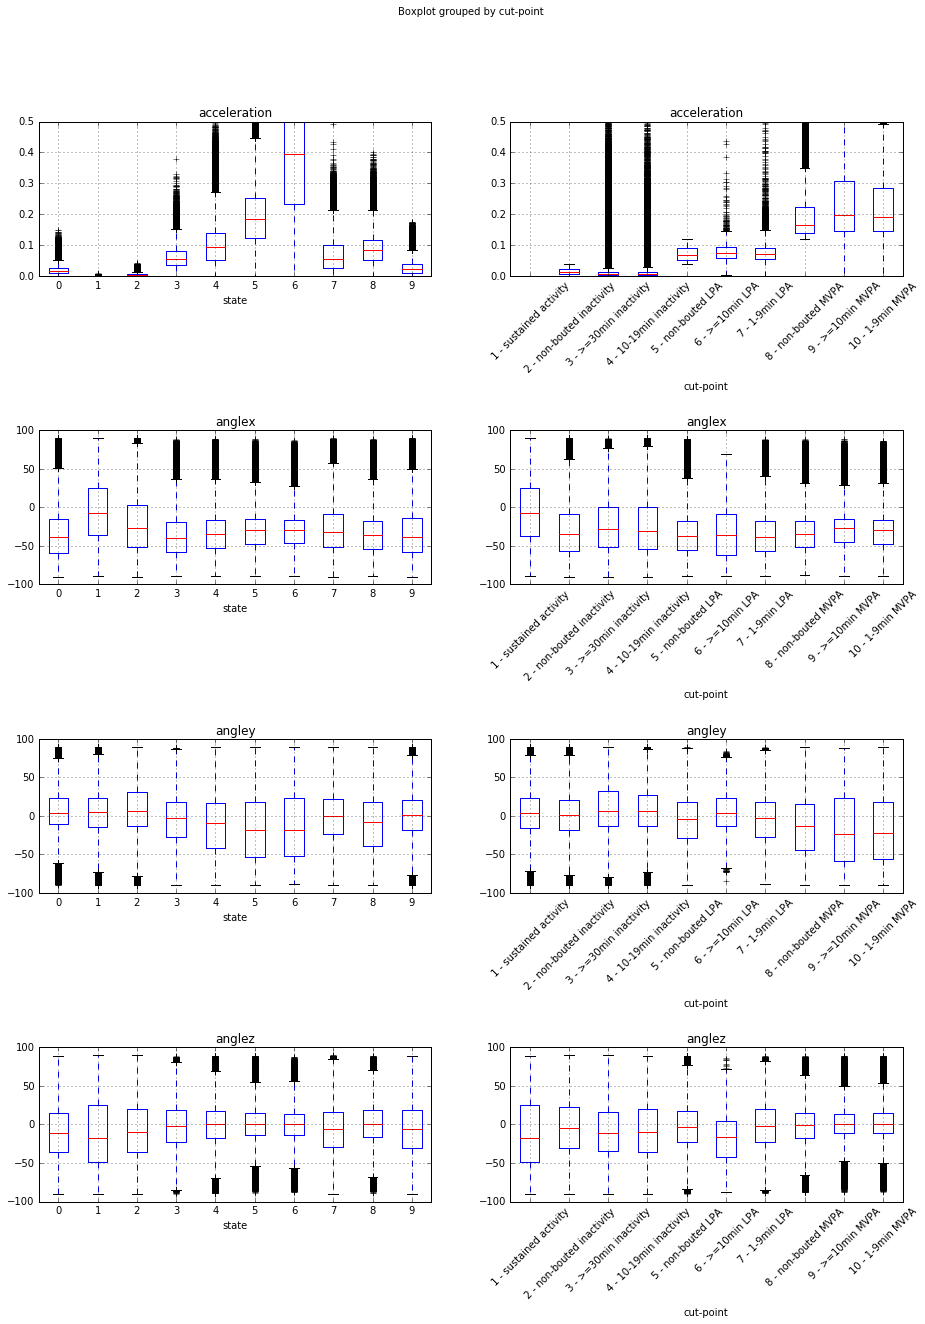

In [36]:
cols = ['acceleration', 'anglex', 'angley', 'anglez']
fig, axes = plt.subplots(len(cols), 2, figsize=(15, 20))
plt.subplots_adjust(hspace=1)
fig.set_label('')
sample.boxplot(by='state', column=cols, ax=axes[:,0])
sample.boxplot(by='cut-point', column=cols, ax=axes[:, 1], rot=45)
ymax_acc = 0.5
axes[0, 0].set_ylim(0, ymax_acc)
axes[0, 1].set_ylim(0, ymax_acc)
plt.savefig(os.path.join(config.image_path, 'boxplots.png'))

# Complete distribution over acceleration

In [37]:
from scipy.stats import gaussian_kde
density = gaussian_kde(sample['acceleration'])

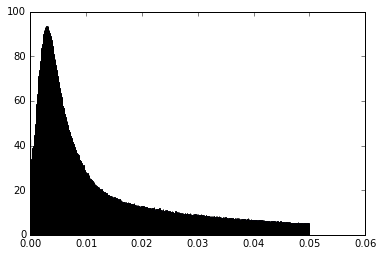

In [38]:
xmin = 0.00000001
xmax = 0.05
ymax = 1
dat = sample['acceleration'] #[sample['acceleration']<xmax]
plt.hist(dat, bins=1000, range=(xmin, xmax), normed=True);
#plt.ylim(0 ,100)

## Get sojourn times

In [39]:
data_sc = pd.read_sql('''select filename, subset, state, heuristic from data_with_states''', conn) 

In [40]:
data_sc['fn_s'] = data_sc['subset'].astype('str') + data_sc['filename']

In [41]:
def sojourn_times(df, colname):
    changepoints = (df[colname].shift(1) != df[colname]) | (df.fn_s.shift(1) != df.fn_s)
    df['block'] = changepoints.astype(int).cumsum()
    sojourn_times = df.groupby([colname, 'block'])['fn_s'].count()
    sojourn_times = sojourn_times.reset_index()[[colname, 'fn_s']]
    sojourn_times.columns = [colname, 'time']
    df.drop('block', 1)
    return sojourn_times

In [42]:
sojourn_times_state = sojourn_times(data_sc, 'state')

In [43]:
sojourn_times_cutoff = sojourn_times(data_sc, 'heuristic')

In [44]:
sojourn_times_state['time_sec'] = sojourn_times_state['time']*5
sojourn_times_cutoff['time_sec'] = sojourn_times_cutoff['time']*5
sojourn_times_state['time_min'] = sojourn_times_state['time']/12.0
sojourn_times_cutoff['time_min'] = sojourn_times_cutoff['time']/12.0

In [45]:
sojourn_times_cutoff['cut-point'] = [get_heuristic(i) for i in sojourn_times_cutoff['heuristic']]

In [46]:
sojourn_times_cutoff.head()

,heuristic,time,time_sec,time_min,cut-point
0,1,355,1775,29.583333,1 - sustained activity
1,1,62,310,5.166667,1 - sustained activity
2,1,368,1840,30.666667,1 - sustained activity
3,1,70,350,5.833333,1 - sustained activity
4,1,609,3045,50.750000,1 - sustained activity


In [47]:
s_grouped = sojourn_times_state.groupby('state')['time_sec']
pd.concat((s_grouped.mean(), s_grouped.std(), s_grouped.max()), axis=1, keys=['mean', 'sigma', 'max'])

,mean,sigma,max
state,,,
0,456.046120,101.985580,830
1,552.989414,136.908076,900
2,123.397287,52.580751,290
3,636.801619,108.340491,970
4,161.239850,48.150405,325
5,152.786358,49.189718,320
6,19.252984,16.004406,350
7,14.585687,10.470824,75
8,420.687974,75.255936,685


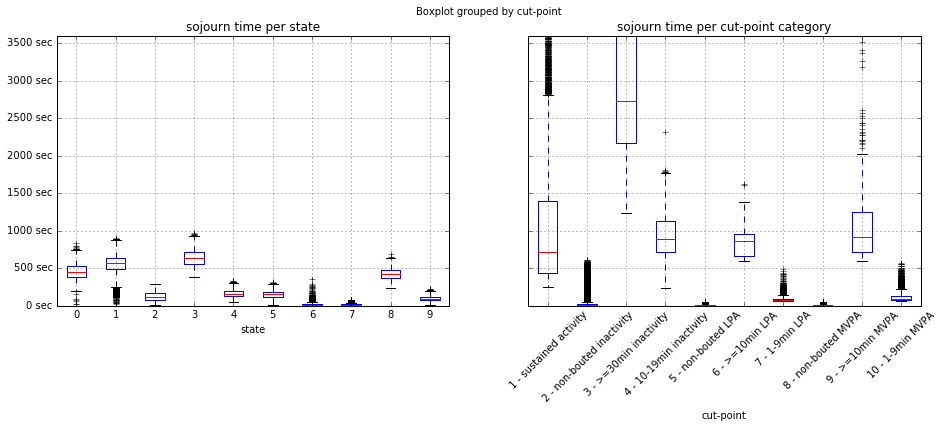

In [48]:
from matplotlib.ticker import FormatStrFormatter
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
fig.set_label('')
ymax = 60*60
sojourn_times_state.boxplot(by='state', column='time_sec', ax=axes[0])
axes[0].set_ylim(top=ymax)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%d sec'))
axes[0].set_title('sojourn time per state')
sojourn_times_cutoff.boxplot(by='cut-point', column='time_sec', ax=axes[1], rot=45)
axes[1].set_ylim(top=ymax)
axes[1].set_title('sojourn time per cut-point category')
plt.savefig(os.path.join(config.image_path, 'sojourn.png'))
#plt.show()

## Cross table activity - state

Let's compare the states with the known activities. First we have look at how many 5-seconds frame we have for each state/activity, and we sort from largest to smallest

In [49]:
ctab_long = pd.read_sql('''select label, state, count(*) from data_with_states group by label, state''', conn) 

In [50]:
ctab = ctab_long.pivot(index='label', columns='state', values='count(*)')

In [51]:
activities_simplified

,Label,"Locomotion (no=0,yes=1,unclear=2)","Frequent arm angle changes (no=0,yes=1,unclear=2)",SUM,Keep variable,Behavioural category,simplified_category
0,Sleeping and resting (including sick in bed),0,0,0,TRUE,0,"low motion, low arm changes"
1,"Did nothing, just relaxing, bored, waiting",0,0,0,TRUE,0,"low motion, low arm changes"
2,"Watch TV, DVDs, downloaded videos",0,0,0,TRUE,0,"low motion, low arm changes"
3,Eating a meal,0,1,1,TRUE,1,"low motion, high arm changes"
4,Reading (not for school),0,1,1,TRUE,1,"low motion, high arm changes"
5,"Answering emails, instant messaging, texting",0,1,1,TRUE,1,"low motion, high arm changes"
6,"Travel by physically active means (walk, bike ...",1,1,2,TRUE,2,"high motion, high arm changes"
7,"Other exercise and sports, dancing, keeping fi...",1,1,2,TRUE,2,"high motion, high arm changes"
8,"Fixing things around the house, fixing bike, g...",1,1,2,TRUE,2,"high motion, high arm changes"
9,"Team ball games and training (e.g. football, h...",1,1,2,TRUE,2,"high motion, high arm changes"


In [52]:
ctab_merged = ctab_long.merge(activities_simplified, left_on='label', right_on='Label')
ctab_simplified_long = ctab_merged.groupby(['simplified_category', 'state'])[['count(*)']].sum()
ctab_simplified = ctab_simplified_long.reset_index().pivot(index='simplified_category', columns='state', values='count(*)')

In [53]:
ctab_simplified

state,0,1,2,3,4,5,6,7,8,9
simplified_category,,,,,,,,,,
"high motion, high arm changes",37783,26166,89544,12120,74438,40791,22551,35908,25344,124475
"low motion, high arm changes",31141,34762,125767,5876,33457,13012,6386,25380,9225,88854
"low motion, low arm changes",78175,1391772,645169,16085,89998,22005,11688,99226,26252,234070
"low motion, mixed arm changes",157233,113017,389196,20066,129661,40380,22173,88180,33710,353264
"mixed motion, high arm changes",25116,54791,102419,9301,42214,13087,5774,23566,14750,85122
"mixed motion, low arm changes",4201,3313,12524,1572,5170,2118,468,2797,1272,11805
"mixed motion, mixed arm changes",65188,63444,202249,14962,86101,32276,14857,52929,23478,199856


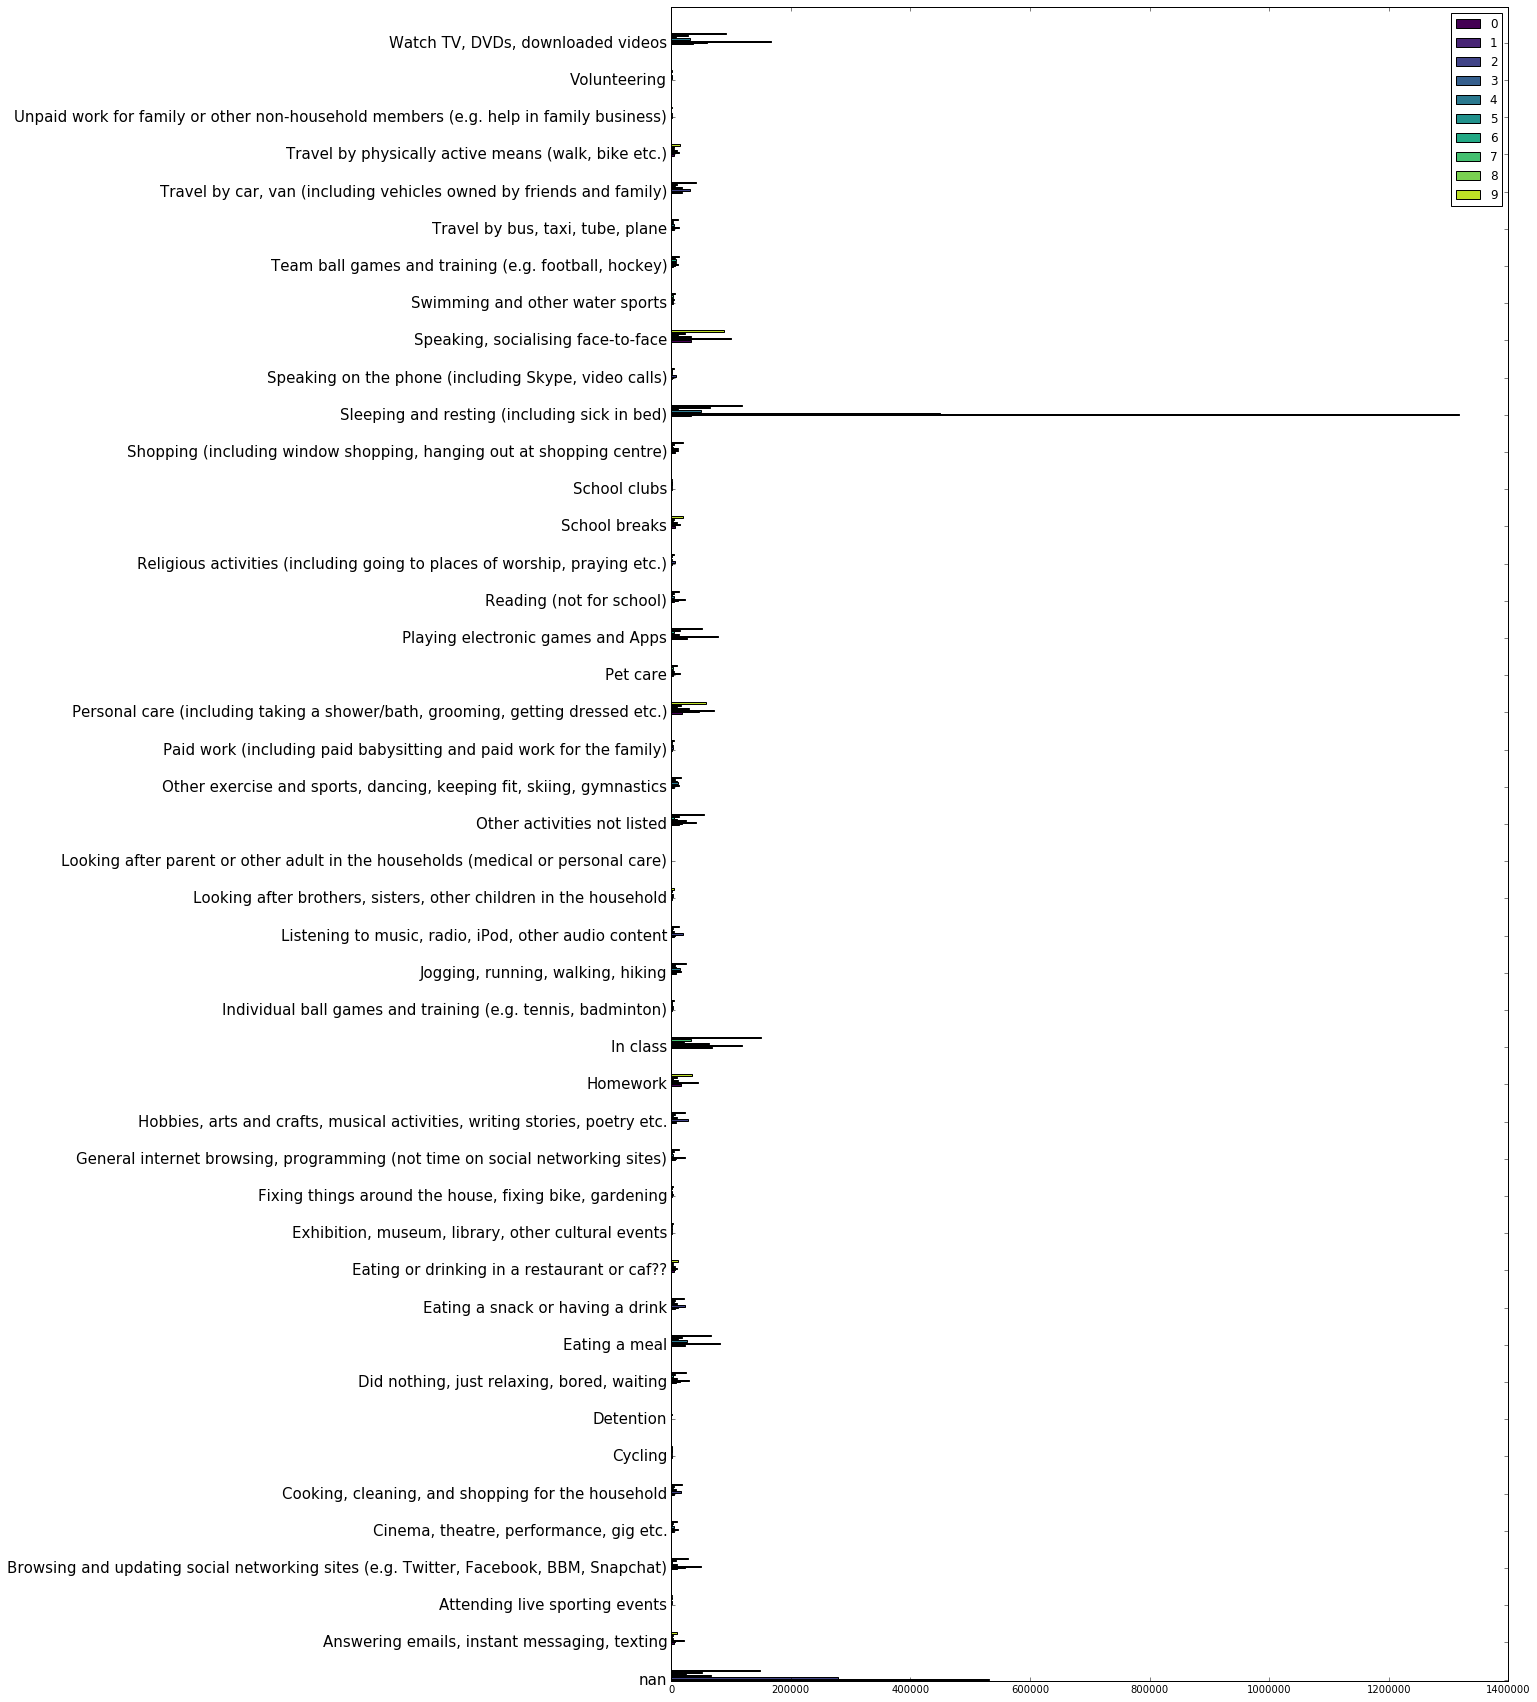

In [54]:
from __future__ import unicode_literals
fig, ax = plt.subplots(figsize=(15,30))

states = ctab.columns
acts = ctab.index

n_groups = len(acts)
index = len(states)*np.arange(n_groups)
bar_width = 1./len(states)*3
colors = colormap

#Draw all states, but don't draw All
for i in range(len(states)):
    rects1 = plt.barh(index + i*bar_width, 
                     ctab[states[i]], 
                     bar_width,
                     color=colors[i],
                     label=states[i])

plt.yticks(index + bar_width, ctab.index, fontsize=15)
plt.legend()

#Set maximum to something reasonable, namely the maximum of not-all
#ax.set_xlim(0, ctab[states[-1]][acts[1]])
plt.show()

In [55]:
#Now normalize over the activity and sort by total number
ctab_norm1 = ctab_simplified.copy()
ctab_norm1.loc['All',:] = ctab_norm1.sum()
ctab_norm1 = ctab_norm1.divide(ctab_norm1.sum(axis=1), axis='index')

In [56]:
ctab_norm1.style.background_gradient(cmap='BuGn',axis=1)

In [57]:
ctab_norm2 = ctab_simplified.copy()
ctab_norm2['All'] = ctab_norm2.sum(axis=1)
ctab_norm2.divide(ctab_norm2.sum(axis=0), axis='columns')

state,0,1,2,3,4,5,6,7,8,9,All
simplified_category,,,,,,,,,,,
"high motion, high arm changes",0.094733,0.015508,0.057148,0.151534,0.161457,0.249229,0.268794,0.109480,0.189091,0.113422,0.081506
"low motion, high arm changes",0.078080,0.020603,0.080266,0.073467,0.072569,0.079502,0.076117,0.077381,0.068827,0.080964,0.062299
"low motion, low arm changes",0.196007,0.824869,0.411757,0.201108,0.195207,0.134448,0.139314,0.302531,0.195865,0.213286,0.435666
"low motion, mixed arm changes",0.394229,0.066982,0.248391,0.250881,0.281237,0.246717,0.264288,0.268853,0.251509,0.321896,0.224442
"mixed motion, high arm changes",0.062973,0.032473,0.065365,0.116289,0.091563,0.079960,0.068822,0.071851,0.110049,0.077564,0.062679
"mixed motion, low arm changes",0.010533,0.001964,0.007993,0.019654,0.011214,0.012941,0.005578,0.008528,0.009490,0.010757,0.007539
"mixed motion, mixed arm changes",0.163445,0.037602,0.129079,0.187067,0.186754,0.197203,0.177086,0.161376,0.175168,0.182110,0.125869


In [58]:
#Now normalize over state and sort by total number
#ind = list(ctab.index)
ctab_norm2 = ctab_simplified.copy()
ctab_norm2.loc['All'] = ctab_norm2.sum(axis=0)
ctab_norm2 = ctab_norm2.divide(ctab_norm2.sum(axis=1), axis='rows')

In [59]:
ctab_norm2.style.background_gradient(cmap='BuGn',axis=0)

Check if there is a significant correlation between the states and the activities:

In [60]:
ctab['All'] = ctab.sum(axis=1)
ctab = ctab.sort_values('All', ascending=False)
ctab = ctab.fillna(0)

In [61]:
topactivities = 10 # take most frequent activities
counts = ctab.as_matrix()[1:1+topactivities,:-1]
chi2, p, dof, expected = scipy.stats.chi2_contingency(counts)

print(chi2, p)

741629.749314 0.0


In [62]:
ctab_reordered = ctab[state_order]

ctab_reordered.head(15).style.background_gradient(cmap='BuGn',axis=1)

In [63]:
# Only easy interpreted activities
activities = ['Sleeping and resting (including sick in bed)', 'Jogging, running, walking, hiking']
ctab_sub = ctab[[a in activities for a in ctab.index]][state_order]
ctab_sub.style.background_gradient(cmap='BuGn',axis=1)

# State vs activity, per person

In [64]:
activity_states = pd.read_sql('''select d.filename, d.state, d.label, count(*)
                from data_with_states d
                join timecounts t
                on t.filename = d.filename
                where t.cnt_hours > 20
                group by d.filename, d.state, d.label;''', 
                               conn)

In [65]:
nr_subjects = len(activity_states['filename'].unique())
ctab_original = activity_states.groupby(['label', 'state'])['count(*)'].sum()
ctab_original = ctab_original.unstack(level=-1)
ctab_original = ctab_original.fillna(0)
ctab = ctab_original / nr_subjects
ctab = ctab[state_order]
ctab['total'] = activity_states.groupby(['label'])['count(*)'].sum() / nr_subjects
ctab = ctab.sort_values('total', ascending=False)
ctab.loc['total',] = ctab.sum(axis=0) 
ctab = ctab / 12.0
ctab

state,1,2,0,9,3,7,8,4,5,6,total
label,,,,,,,,,,,
Sleeping and resting (including sick in bed),274.762605,87.405462,5.795752,22.544818,1.499300,12.800187,2.857143,9.221289,1.924136,0.993231,419.803922
In class,2.813725,20.106443,12.807190,27.999300,1.091503,5.908497,2.814659,11.709384,3.894258,1.555322,90.700280
"Watch TV, DVDs, downloaded videos",12.732726,34.318627,7.633987,18.577264,1.020775,5.686508,1.545985,6.214753,1.789449,0.928105,90.448179
"Speaking, socialising face-to-face",4.008637,18.663866,5.414799,16.136555,1.073296,4.315126,1.613445,5.975957,2.165500,1.066993,60.434174
"Personal care (including taking a shower/bath, grooming, getting dressed etc.)",9.479225,12.655462,3.268908,11.054622,1.334034,2.977824,2.003035,5.956583,1.734827,0.655929,51.120448
Eating a meal,2.806256,15.356676,4.408730,13.014239,0.872549,3.523109,1.266573,5.228992,2.229458,0.915266,49.621849
Playing electronic games and Apps,5.023343,15.971755,5.383053,10.833333,0.446545,3.098273,0.650093,2.635621,0.689776,0.800420,45.532213
Other activities not listed,2.853408,7.575397,2.739729,10.448413,0.913632,2.583567,1.253735,4.711251,1.882353,0.822829,35.784314
"Travel by car, van (including vehicles owned by friends and family)",1.545051,5.602474,3.747899,8.291083,1.003501,1.921802,0.927171,3.467320,1.170401,0.614613,28.291317


In [66]:
ctab_f = ctab.applymap(lambda c: '{:.1f}'.format(c))

In [67]:
nr_subjects

357

In [ ]:
ctab[state_order].style.background_gradient(cmap='BuGn',axis=0)

## Look more into depth into sleep

In [69]:
data_sleep = pd.read_sql('''select filename, timestamp, subset, heuristic, state, label from data_with_states where label="Sleeping and resting (including sick in bed)" ''', conn) 

In [70]:
data_sleep.head()

,filename,timestamp,subset,heuristic,state,label
0,__022240_2015-03-31 12-12-28.bin_day2.csv,2015-03-26 21:50:00,1,3,0,Sleeping and resting (including sick in bed)
1,__022240_2015-03-31 12-12-28.bin_day2.csv,2015-03-26 21:50:05,1,3,0,Sleeping and resting (including sick in bed)
2,__022240_2015-03-31 12-12-28.bin_day2.csv,2015-03-26 21:50:10,1,3,0,Sleeping and resting (including sick in bed)
3,__022240_2015-03-31 12-12-28.bin_day2.csv,2015-03-26 21:50:15,1,3,0,Sleeping and resting (including sick in bed)
4,__022240_2015-03-31 12-12-28.bin_day2.csv,2015-03-26 21:50:20,1,3,0,Sleeping and resting (including sick in bed)


In [71]:
data_sleep.timestamp2 = pd.to_datetime(data_sleep.timestamp)

In [72]:
data_sleep['time'] = data_sleep.timestamp2.dt.time

In [73]:
data_sleep_grouped = data_sleep.groupby(['time', 'state'])['filename'].count()
data_sleep_grouped = data_sleep_grouped.unstack()[state_order]

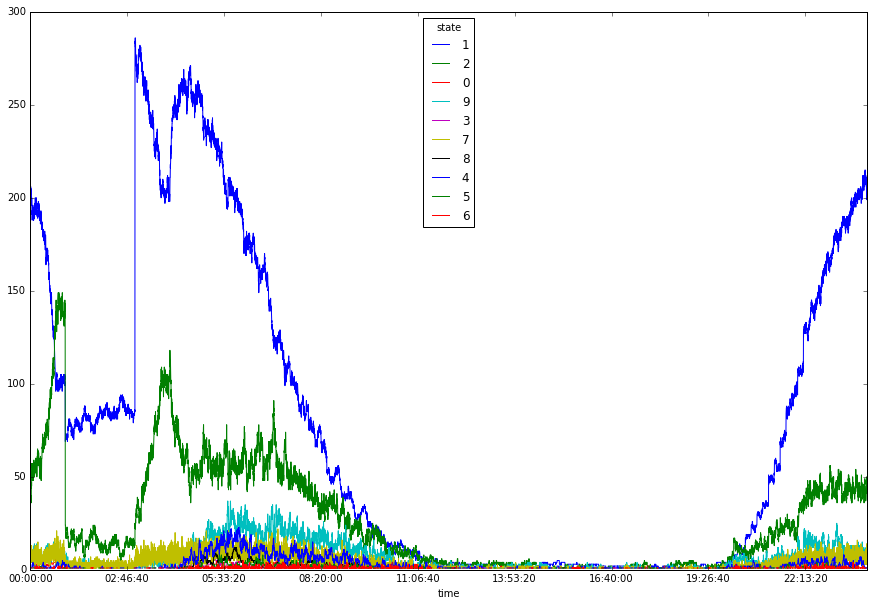

In [74]:
data_sleep_grouped.plot(figsize=(15,10));

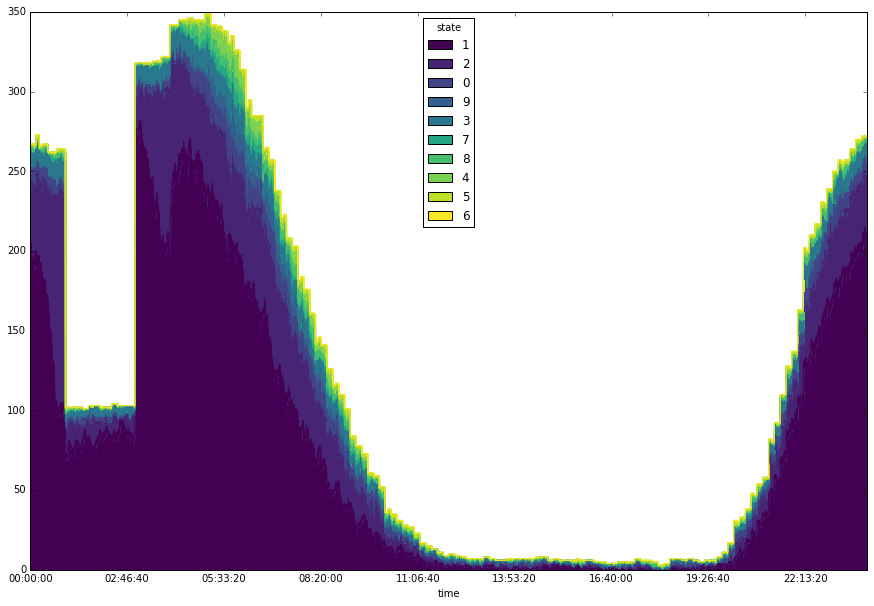

In [75]:
data_sleep_grouped.plot(figsize=(15,10), kind='area', stacked=True, colormap=cmap);

In [76]:
data_sleep_grouped = data_sleep_grouped.fillna(0)
counts = data_sleep_grouped.mean(axis=1)
data_sleep_grouped_norm = pd.DataFrame((data_sleep_grouped.as_matrix().transpose() / counts.as_matrix()).transpose())
data_sleep_grouped_norm.index = data_sleep_grouped.index

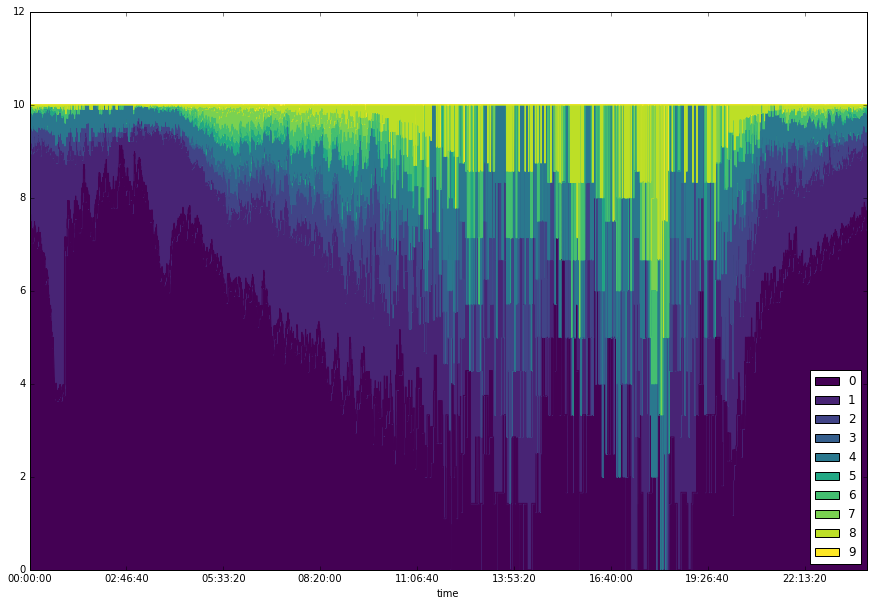

In [77]:
data_sleep_grouped_norm.plot(figsize=(15,10), kind='area', stacked=True, colormap=cmap);

## Compare with heuristic

In [78]:
ctab_heuristic_long = pd.read_sql('''select heuristic, state, count(*) from data_with_states group by heuristic, state''', conn)

In [79]:
ctab_heuristic = ctab_heuristic_long.pivot(index='heuristic', columns='state', values='count(*)').fillna(0)

In [80]:
ctab_heuristic.index = [get_heuristic(i) for i in ctab_heuristic.index]

In [81]:
ctab_heuristic_norm = ctab_heuristic.divide(ctab_heuristic.sum(axis=0), axis=1)
ctab_heuristic_norm.style.background_gradient(cmap='BuGn',axis=0)

In [82]:
ctab_heuristic_norm = ctab_heuristic.divide(ctab_heuristic.sum(axis=1), axis=0)
ctab_heuristic_norm.style.background_gradient(cmap='BuGn',axis=1)

## Heuristic vs states, per person

In [83]:
heuristic_states = pd.read_sql('''select d.filename, d.state, d.heuristic, count(*)
                from data_with_states d
                join timecounts t
                on t.filename = d.filename
                where t.cnt_hours > 20
                group by d.filename, d.state, d.heuristic;''', 
                               conn)

In [84]:
nr_subjects = len(heuristic_states['filename'].unique())
ctab_original = heuristic_states.groupby(['state', 'heuristic'])['count(*)'].sum()
ctab_original = ctab_original.unstack(level=-1)
ctab_original = ctab_original.fillna(0)
ctab = ctab_original / nr_subjects
ctab['total'] = heuristic_states.groupby(['state'])['count(*)'].sum() / nr_subjects
ctab.loc['total',] = ctab.sum(axis=0) 
ctab.applymap(lambda c: float(c)/nr_subjects)
ctab.applymap(lambda c: float(c)/12.0)
ctab.columns = [get_heuristic(i) for i in ctab.columns[:-1]] + ['total']
ctab_f = ctab.applymap(lambda c: '{:.0f}'.format(c))

In [85]:
ctab_f

,1 - sustained activity,2 - non-bouted inactivity,3 - >=30min inactivity,4 - 10-19min inactivity,5 - non-bouted LPA,6 - >=10min LPA,7 - 1-9min LPA,8 - non-bouted MVPA,9 - >=10min MVPA,10 - 1-9min MVPA,total
state,,,,,,,,,,,
0,0,333,399,264,52,0,0,0,0,0,1049
1,5186,56,100,58,0,0,0,0,0,0,5401
2,1,1040,2113,1087,0,0,0,0,0,0,4241
3,0,65,1,0,90,3,46,15,0,0,220
4,0,200,31,10,499,0,47,308,40,85,1220
5,0,18,1,1,62,0,0,80,102,168,432
6,0,5,7,3,11,0,0,91,43,62,223
7,23,159,188,100,277,0,9,102,13,14,885
8,0,57,3,1,157,2,53,70,4,11,357


In [86]:
#obs = ctab_original.as_matrix()
obs = ctab.as_matrix()[:-1,:-1]
expected = np.outer(obs.sum(axis=1), obs.sum(axis=0))/obs.sum()
scipy.stats.chisquare(obs, expected, axis=None)

Power_divergenceResult(statistic=33763.74748456019, pvalue=0.0)

In [87]:
ctab.transpose()[list(state_order)+['total']]

state,1,2,0,9,3,7,8,4,5,6,total
1 - sustained activity,5186.498599,1.190476,0.005602,0.044818,0.000000,22.655462,0.000000,0.002801,0.000000,0.000000,5210.397759
2 - non-bouted inactivity,56.095238,1039.563025,333.453782,1456.473389,64.843137,159.448179,56.574230,200.154062,18.476190,4.633053,3389.714286
3 - >=30min inactivity,100.100840,2112.980392,399.151261,550.865546,1.123249,188.173669,2.655462,30.593838,1.319328,7.092437,3394.056022
4 - 10-19min inactivity,58.299720,1087.154062,264.025210,300.156863,0.436975,99.571429,0.708683,9.644258,0.523810,2.983193,1823.504202
5 - non-bouted LPA,0.000000,0.002801,52.254902,555.599440,90.168067,276.579832,157.383754,498.537815,61.689076,11.392157,1703.607843
6 - >=10min LPA,0.000000,0.000000,0.000000,0.100840,3.142857,0.025210,1.840336,0.484594,0.000000,0.016807,5.610644
7 - 1-9min LPA,0.000000,0.000000,0.156863,31.778711,46.005602,9.058824,53.271709,47.406162,0.431373,0.246499,188.355742
8 - non-bouted MVPA,0.000000,0.000000,0.044818,4.966387,14.515406,101.859944,69.509804,307.792717,80.190476,90.823529,669.703081
9 - >=10min MVPA,0.000000,0.036415,0.000000,0.736695,0.025210,13.215686,3.683473,40.476190,102.134454,43.453782,203.761905
10 - 1-9min MVPA,0.000000,0.000000,0.000000,0.000000,0.025210,14.403361,11.456583,85.394958,167.585434,62.002801,340.868347


## Distributions for the heuristic levels

## States for an example sequence

In [92]:
example_index = 9 #674

In [93]:
fn = filenames[example_index]
data = pd.read_csv(os.path.join(config.states_path,fn), encoding='utf-8', index_col='timestamp', parse_dates=True)
data.head()

,acceleration,EN,anglex,angley,anglez,roll_med_acc_x,roll_med_acc_y,roll_med_acc_z,dev_roll_med_acc_x,dev_roll_med_acc_y,...,filename,subset,switched_pos,binFile,day,slot,activity,label,start_time,state
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-11-23 21:30:00,0,1.000723,14.802394,73.986604,5.972468,0.255606,0.961648,0.104099,-0.001466,0.00042,...,__023161_2015-12-10 10-06-37.bin_day2.csv,1,False,__023161_2015-12-10 10-06-37.bin,2,106,3,Homework,2015-11-23T21:30:00+0000,1
2015-11-23 21:30:05,0,1.000279,14.615390,74.158633,5.977607,0.252231,0.961648,0.104099,0.001105,0.00038,...,__023161_2015-12-10 10-06-37.bin_day2.csv,1,False,__023161_2015-12-10 10-06-37.bin,2,106,3,Homework,2015-11-23T21:30:00+0000,1
2015-11-23 21:30:10,0,1.001247,14.599013,74.130140,6.086628,0.251990,0.961648,0.106006,0.001266,0.00114,...,__023161_2015-12-10 10-06-37.bin_day2.csv,1,False,__023161_2015-12-10 10-06-37.bin,2,106,3,Homework,2015-11-23T21:30:00+0000,1
2015-11-23 21:30:15,0,1.000775,14.686597,74.093321,5.975158,0.253537,0.961728,0.104099,0.000241,0.00066,...,__023161_2015-12-10 10-06-37.bin_day2.csv,1,False,__023161_2015-12-10 10-06-37.bin,2,106,3,Homework,2015-11-23T21:30:00+0000,1
2015-11-23 21:30:20,0,1.000237,14.602033,74.170921,5.977974,0.251990,0.961648,0.104099,0.001627,0.00022,...,__023161_2015-12-10 10-06-37.bin_day2.csv,1,False,__023161_2015-12-10 10-06-37.bin,2,106,3,Homework,2015-11-23T21:30:00+0000,1


In [94]:
hidden_states = data['state']

In [95]:
#state_order = [5, 6, 8, 9, 0, 7, 4, 3, 2, 1]

In [96]:
from pyhsmm.util.general import rle
from matplotlib.dates import date2num, AutoDateLocator

def plot_states_and_var(data, hidden_states, state_order = None, cmap=None, columns=None, by=None, by_labels=None):
    """
    Make  a plot of the data and the states
    Parameters
    ----------
    data : pandas DataFrame
        Data to plot
    hidden_states: iteretable
        the hidden states corresponding to the timesteps
    columns : list, optional
        Which columns to plot
    by : iteretable
        The column to group on
    """
    fig, ax = plt.subplots(figsize=(20, 5))
    if columns is None:
        columns = data.columns
    df = data[columns].copy()
    stateseq = np.array(hidden_states)
    stateseq_norep, durations = rle(stateseq)
    datamin, datamax = np.array(df).min(), np.array(df).max()
    y = np.array(
        [datamin, datamax])
    maxstate = stateseq.max() + 1
    
    if state_order is None:
        state_order = np.arange(maxstate)
    state_order_dict = {state_order[i]: i for i in range((len(state_order)))}
    x = np.hstack(([0], durations.cumsum()[:-1], [len(df.index) - 1]))
    C = np.array(
        [[float(state_order_dict[state]) / maxstate] for state in stateseq_norep]).transpose()
    ax.set_xlim((min(x), max(x)))

    if cmap is None:
        num_states = max(hidden_states) + 1
        colormap, cmap = get_color_map(num_states)
    pc = ax.pcolorfast(x, y, C, vmin=0, vmax=1, alpha=0.3, cmap=cmap)
    plt.plot(df.as_matrix())
    locator = AutoDateLocator()
    locator.create_dummy_axis()
    num_index = pd.Index(df.index.map(date2num))
    ticks_num = locator.tick_values(min(df.index), max(df.index))
    ticks = [num_index.get_loc(t) for t in ticks_num]
    plt.xticks(ticks, df.index.strftime('%H:%M')[ticks], rotation='vertical')
    cb = plt.colorbar(pc)
    cb.set_ticks(np.arange(1./(2*cmap.N), 1, 1./cmap.N))
    cb.set_ticklabels(state_order)
    # Plot the activities
    if by is not None:
        
        highest = ax.transData.transform((0.0,1.0))
        lowest = ax.transData.transform((0.0,0.0))
        y_to_pix_ratio = highest[1] - lowest[1]
        print(highest, lowest, y_to_pix_ratio)
        slen_p = 30
        slen_d = slen_p / float(y_to_pix_ratio)
            
        sca = ax.scatter(
            np.arange(len(hidden_states)), #data.index,
            np.ones_like(hidden_states) * datamax +  0.7*slen_d,
            c=by,
            cmap=cmap,
            edgecolors='none', 
            marker='|',
            lw=4,
            s=slen_p**2
        )
        ax.set_ylim((datamin, datamax + slen_d*1.4))
        if by_labels is not None:
            cb2 = plt.colorbar(sca)
            cb2.set_ticks(np.arange(1./2., cmap.N-0.5, 1))
            cb2.set_ticklabels(by_labels)
    return fig, ax

[  180.   2974.5] [ 180.   184.5] 2790.0


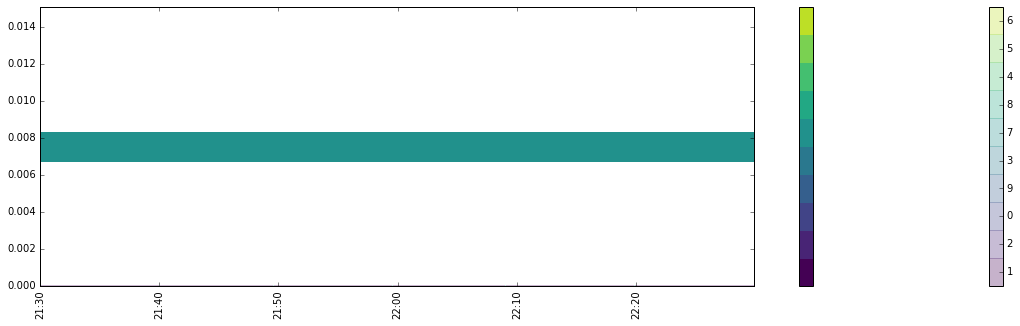

In [97]:
heuristic_seq = np.array(data['heuristic']) - 1
fig, ax = plot_states_and_var(data, hidden_states, state_order=state_order, 
                              columns=['acceleration',], by=heuristic_seq, by_labels = heuristic_classes,
                              cmap=cmap_states);
cbar = ax.images[-1].colorbar
#cbar.set_ticklabels(state_order)
#cbar.ax.invert_yaxis() 
plt.show()

(0, 23)


IndexError: index 0 is out of bounds for axis 1 with size 0

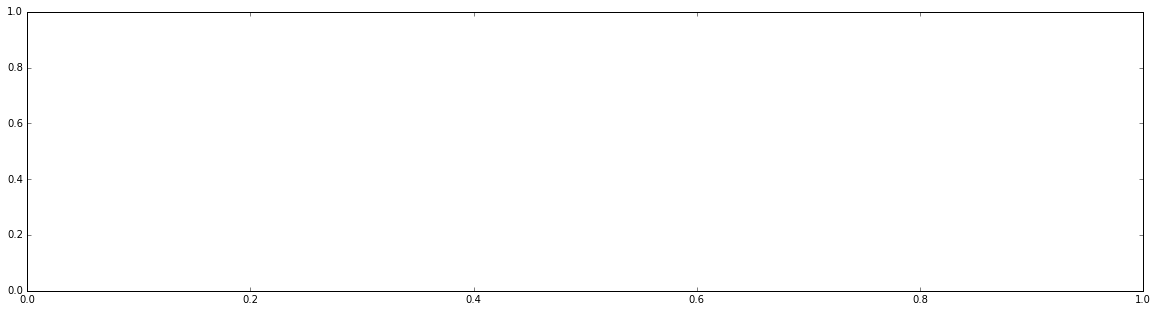

In [98]:
start =int(6*12*60)
end = 8*12*60
print(data[start:end].shape)
fig, ax = plot_states_and_var(data[start:end], hidden_states[start:end], 
                              by=heuristic_seq[start:end], state_order=state_order, 
                              cmap=cmap_states, columns=['acceleration'], 
                              by_labels = heuristic_classes)
ax.set_title('acceleration');

In [ ]:
start =int(6.7*12*60)
end = int(7.5*12*60)
print(data[start:end].shape)
fig, ax = plot_states_and_var(data[start:end], hidden_states[start:end], 
                              by=heuristic_seq[start:end], state_order=state_order, 
                              cmap=cmap_states, columns=['acceleration'], 
                              by_labels = heuristic_classes)
ax.set_title('acceleration');

(0, 23)


IndexError: index 0 is out of bounds for axis 1 with size 0

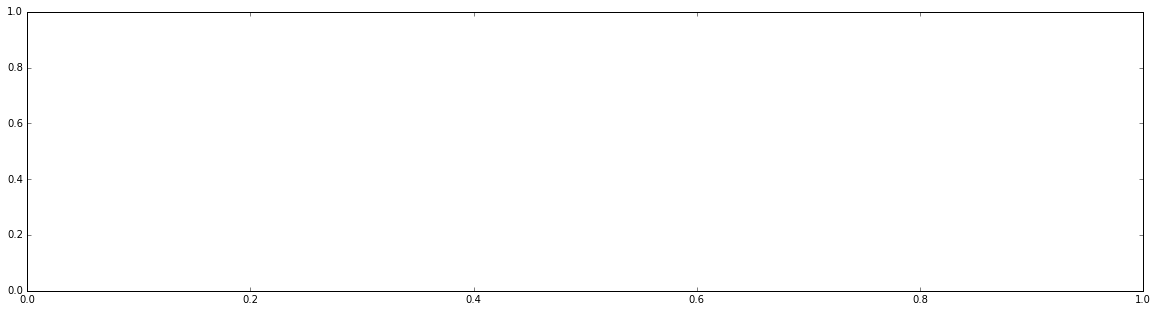

In [99]:
start =int(4*12*60)
end = 6*12*60
print(data[start:end].shape)
fig, ax = plot_states_and_var(data[start:end], hidden_states[start:end], 
                              state_order=state_order, cmap=cmap_states, 
                              columns=['anglex', 'angley', 'anglez'], 
                              by=heuristic_seq[start:end], 
                              by_labels = heuristic_classes)
ax.set_title('Angles');

In [ ]:
start =int(8*12*60)
end = 9*12*60
fig, ax = plot_states_and_var(data[start:end], hidden_states[start:end], 
                              by=heuristic_seq[start:end], state_order=state_order, 
                              cmap=cmap_states, columns=['acceleration'], 
                              by_labels = heuristic_classes)
ax.set_title('acceleration')

In [ ]:
fig, ax = plot_states_and_var(data[start:end], hidden_states[start:end], 
                              by=heuristic_seq[start:end], state_order=state_order, 
                              cmap=cmap_states, columns=['anglex', 'angley', 'anglez'], 
                              by_labels = heuristic_classes)
ax.set_title('acceleration');